In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
    .config("spark.driver.memory", "8g")\
    .getOrCreate()

spark

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.sql.window import Window
from pyspark.sql.functions import col, lit

from common import *

pd.set_option('display.max_rows', 100)

In [5]:
PREFIX = "main/tpcc"

client_sdf = spark.read.csv(f"{PREFIX}/*/client/0/metadata.csv", header=True)\
    .withColumn(
        "prefix",
        ancestor_udf(F.input_file_name(), lit(3))
    )

server_sdf = spark.read.csv(f"{PREFIX}/*/server/0-0/metadata.csv", header=True)\
    .withColumn(
        "prefix",
        ancestor_udf(F.input_file_name(), lit(3))
    )

index_sdf = server_sdf.join(client_sdf, on='prefix')\
    .withColumn("duration", col("duration").cast(T.IntegerType()))\
    .withColumn("txns", col("txns").cast(T.IntegerType()))\
    .withColumn("clients", col("clients").cast(T.IntegerType()))\
    .withColumn("rate", col("rate").cast(T.IntegerType()))\
    .withColumn("sample", col("sample").cast(T.IntegerType()))

index_sdf.toPandas()

,prefix,version,config_name,duration,txns,clients,rate,sample,wl:name,wl:sh_only,wl:mix,wl:mh_zipf,wl:homes,wl:sp_partition
0,file:///home/ctring/data/slog/main/tpcc/baseli...,1.0.916,baseline.conf,30,0,100,0,10,tpcc,0,45:43:4:4:4,1,2,-1
1,file:///home/ctring/data/slog/main/tpcc/baseli...,1.0.916,baseline.conf,30,0,112,0,10,tpcc,0,45:43:4:4:4,1,2,-1
2,file:///home/ctring/data/slog/main/tpcc/ddr_ts...,1.0.916,ddr_ts.conf,30,0,100,0,10,tpcc,0,45:43:4:4:4,1,2,-1
3,file:///home/ctring/data/slog/main/tpcc/ddr_ts...,1.0.916,ddr_ts.conf,30,0,112,0,10,tpcc,0,45:43:4:4:4,1,2,-1
4,file:///home/ctring/data/slog/main/tpcc/baseli...,1.0.916,baseline.conf,30,0,12,0,10,tpcc,0,45:43:4:4:4,1,2,-1
5,file:///home/ctring/data/slog/main/tpcc/baseli...,1.0.916,baseline.conf,30,0,25,0,10,tpcc,0,45:43:4:4:4,1,2,-1
6,file:///home/ctring/data/slog/main/tpcc/baseli...,1.0.916,baseline.conf,30,0,37,0,10,tpcc,0,45:43:4:4:4,1,2,-1
7,file:///home/ctring/data/slog/main/tpcc/baseli...,1.0.916,baseline.conf,30,0,50,0,10,tpcc,0,45:43:4:4:4,1,2,-1
8,file:///home/ctring/data/slog/main/tpcc/baseli...,1.0.916,baseline.conf,30,0,62,0,10,tpcc,0,45:43:4:4:4,1,2,-1
9,file:///home/ctring/data/slog/main/tpcc/baseli...,1.0.916,baseline.conf,30,0,75,0,10,tpcc,0,45:43:4:4:4,1,2,-1


# Throughput

In [4]:
# Extract all prefixes in the index
throughput_df = index_sdf.select("prefix", "sample").toPandas()
# Compute the throughput of each prefix
throughput_df["throughput"] = throughput_df.apply(
    lambda row: throughput(
        spark,
        row["prefix"],
        row["sample"],
        trim_start_sec=0,
        trim_end_sec=0,
        new_version=True,
    ).first().throughput,
    axis=1
)
# Associate metadata from the index to the throughputs
throughput_df = throughput_df.merge(index_sdf.drop("sample").toPandas(), on="prefix")
# Try to cast columns to appropriate types 
throughput_df = throughput_df.convert_dtypes()

throughput_df.sort_values(by="config_name")

,prefix,sample,throughput,version,config_name,duration,txns,clients,rate,wl:name,wl:sh_only,wl:mix,wl:mh_zipf,wl:homes,wl:sp_partition
0,file:///home/ctring/data/slog/main/tpcc/baseli...,10,33040.874794,1.0.916,baseline.conf,30,0,100,0,tpcc,0,45:43:4:4:4,1,2,-1
10,file:///home/ctring/data/slog/main/tpcc/baseli...,10,32366.184161,1.0.916,baseline.conf,30,0,87,0,tpcc,0,45:43:4:4:4,1,2,-1
18,file:///home/ctring/data/slog/main/tpcc/baseli...,10,494.696929,1.0.916,baseline.conf,30,0,1,0,tpcc,0,45:43:4:4:4,1,2,-1
8,file:///home/ctring/data/slog/main/tpcc/baseli...,10,29187.334111,1.0.916,baseline.conf,30,0,62,0,tpcc,0,45:43:4:4:4,1,2,-1
7,file:///home/ctring/data/slog/main/tpcc/baseli...,10,24877.472267,1.0.916,baseline.conf,30,0,50,0,tpcc,0,45:43:4:4:4,1,2,-1
6,file:///home/ctring/data/slog/main/tpcc/baseli...,10,20841.429256,1.0.916,baseline.conf,30,0,37,0,tpcc,0,45:43:4:4:4,1,2,-1
9,file:///home/ctring/data/slog/main/tpcc/baseli...,10,32038.568659,1.0.916,baseline.conf,30,0,75,0,tpcc,0,45:43:4:4:4,1,2,-1
4,file:///home/ctring/data/slog/main/tpcc/baseli...,10,6763.850164,1.0.916,baseline.conf,30,0,12,0,tpcc,0,45:43:4:4:4,1,2,-1
1,file:///home/ctring/data/slog/main/tpcc/baseli...,10,33705.378065,1.0.916,baseline.conf,30,0,112,0,tpcc,0,45:43:4:4:4,1,2,-1
5,file:///home/ctring/data/slog/main/tpcc/baseli...,10,13704.258196,1.0.916,baseline.conf,30,0,25,0,tpcc,0,45:43:4:4:4,1,2,-1


<AxesSubplot:xlabel='Number of clients'>

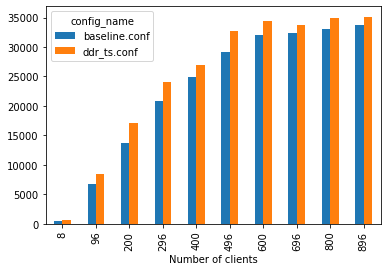

In [6]:
remove_constant_columns(throughput_df, ["config_name", "throughput"])
pivot_values = "throughput"
pivot_columns = "config_name"
pivot_index = throughput_df.columns.drop([pivot_values, pivot_columns, "prefix"])
pivoted = throughput_df.pivot(index=pivot_index, columns=pivot_columns, values=pivot_values)
pivoted["Number of clients"] = pivoted.index * 8
pivoted.sort_index().plot.bar(x="Number of clients")
# pivoted.sort_index().plot.bar()

## By Region

No handles with labels found to put in legend.


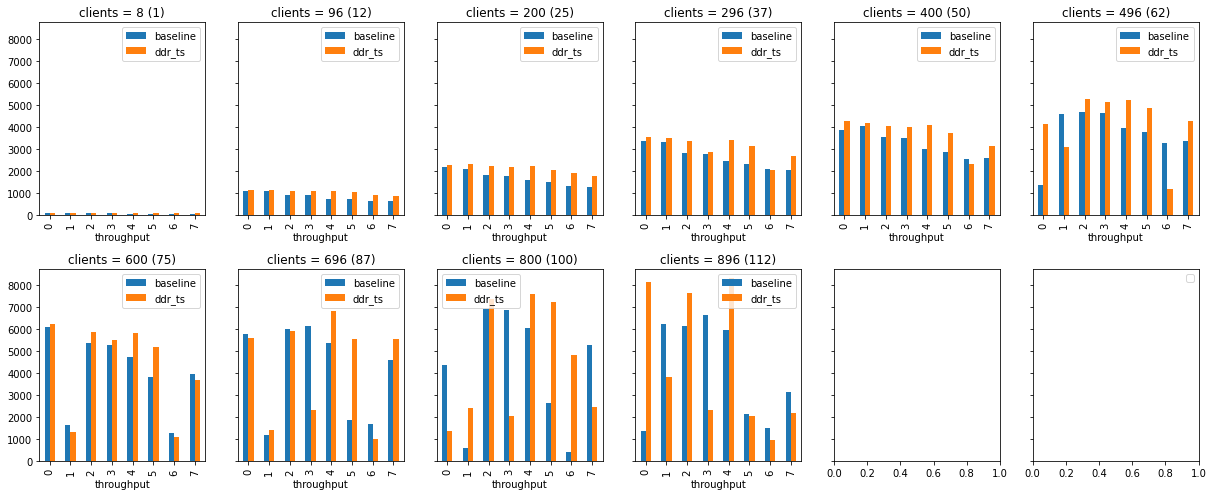

In [20]:
rows = 2
cols = 6
_, ax = plt.subplots(rows, cols, figsize=(17, 7), sharey=True)

index_df = index_sdf.toPandas()
clients_values = sorted(index_df["clients"].unique())
for i, clients in enumerate(clients_values):
    filtered = index_df.loc[index_df.clients == clients]

    baseline_prefix = filtered.loc[filtered.config_name == "baseline.conf", "prefix"].iat[0]
    baseline_sample = filtered.loc[filtered.config_name == "baseline.conf", "sample"].iat[0]
    baseline_throughput_per_region = throughput(
        spark,
        baseline_prefix,
        baseline_sample,
        per_region=True,
        trim_start_sec=5,
        trim_end_sec=5,
    )

    ddr_ts_prefix = filtered.loc[filtered.config_name == "ddr_ts.conf", "prefix"].iat[0]
    ddr_ts_sample = filtered.loc[filtered.config_name == "ddr_ts.conf", "sample"].iat[0]
    ddr_ts_throughput_per_region = throughput(
        spark,
        ddr_ts_prefix,
        ddr_ts_sample,
        per_region=True,
        trim_start_sec=5,
        trim_end_sec=5,
    )

    cmp = baseline_throughput_per_region.withColumnRenamed("throughput", "baseline")\
        .join(ddr_ts_throughput_per_region.withColumnRenamed("throughput", "ddr_ts"), "machine")\
        .toPandas()\
        .sort_values("machine")
 
    r, c = i // cols, i % cols
    cmp.plot.bar(ax=ax[r, c], x="machine")

    ax[r, c].set_title(f"clients = {clients * 8} ({clients})")
    ax[r, c].set_xlabel("throughput")

plt.legend()
plt.tight_layout()

# Latency

In [17]:
prefixes = list(map(lambda r : r.prefix, index_sdf.select("prefix").collect()))
latency_sdf = latency(spark, prefixes).withColumn("coordinator_region", (col("coordinator") / 3).cast(T.IntegerType()))
latency_sdf = latency_sdf.join(index_sdf, on="prefix").orderBy("clients").cache()
latency_sdf.show()

+--------------------+------+-----------+--------+----------+---------+------------------+-------+-------------+--------+----+-------+----+------+-------+----------+-----------+----------+--------+---------------+
|              prefix|txn_id|coordinator|replicas|partitions|  latency|coordinator_region|version|  config_name|duration|txns|clients|rate|sample|wl:name|wl:sh_only|     wl:mix|wl:mh_zipf|wl:homes|wl:sp_partition|
+--------------------+------+-----------+--------+----------+---------+------------------+-------+-------------+--------+----+-------+----+------+-------+----------+-----------+----------+--------+---------------+
|file:///home/ctri...| 29603|          3|  [0, 1]|       [2]| 24.85888|                 1|1.0.916|baseline.conf|      30|   0|      1|   0|    10|   tpcc|         0|45:43:4:4:4|         1|       2|             -1|
|file:///home/ctri...| 58103|          3|     [1]|       [1]| 7.582208|                 1|1.0.916|baseline.conf|      30|   0|      1|   0|    1

## By number of clients

Clients = 12: Baseline...done DDR-TS...done
Clients = 1: Baseline...done DDR-TS...done
Clients = 112: Baseline...done DDR-TS...done
Clients = 37: Baseline...done DDR-TS...done
Clients = 100: Baseline...done DDR-TS...done
Clients = 87: Baseline...done DDR-TS...done
Clients = 50: Baseline...done DDR-TS...done
Clients = 25: Baseline...done DDR-TS...done
Clients = 62: Baseline...done DDR-TS...done
Clients = 75: Baseline...done DDR-TS...done


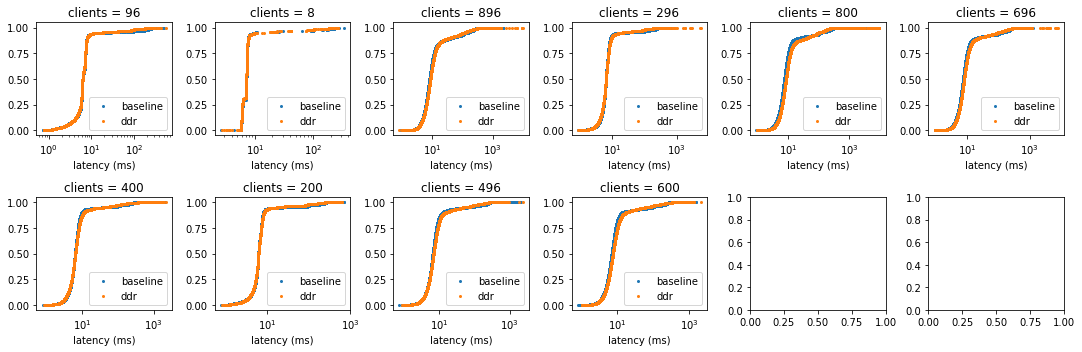

In [23]:
all_clients = index_sdf.select("clients")\
    .distinct()\
    .rdd.map(lambda r : r.clients)\
    .collect()

rows = 2
cols = 6
_, ax = plt.subplots(rows, cols, figsize=(15, 5))

for i, clients in enumerate(all_clients):
    print(f"Clients = {clients}:", end='')
    by_clients = latency_sdf.where(col("clients") == clients).cache()

    r, c = i // cols, i % cols

    print(" Baseline...", end='')
    baseline = by_clients.where(col("config_name") == "baseline.conf").select("latency")
    plot_cdf(ax[r, c], collect_col(baseline, "latency"), label="baseline", linewidth=0, marker='o')
    print("done", end='')

    print(" DDR-TS...", end='')
    ddr_ts = by_clients.where(col("config_name") == "ddr_ts.conf").select("latency")
    plot_cdf(ax[r, c], collect_col(ddr_ts, "latency"), label="ddr", linewidth=0, marker='o')
    print("done", end='')
    
    ax[r, c].set_title(f"clients = {clients * 8}")
    ax[r, c].set_xlabel("latency (ms)")
    ax[r, c].legend()
    print()

plt.tight_layout()

# By regions

In [29]:
def plot_latency_per_region(sdf_dict):
    rows = 2
    cols = 4
    _, ax = plt.subplots(rows, cols, figsize=(15, 7))

    for i in range(8):
        r, c = i // cols, i % cols
        
        for label, sdf in sdf_dict.items():
            plot_cdf(
                ax[r, c],
                collect_col(sdf.where(col("coordinator_region") == i), "latency"),
                label=label,
                linewidth=0,
                marker='o'
            )

        ax[r, c].set_title(f"region = {i}")
        ax[r, c].set_xlabel("latency (ms)")
        ax[r, c].legend()

In [18]:
CLIENTS = 75
baseline_sdf = latency_sdf.where((col("config_name") == "baseline.conf") & (col("clients") == CLIENTS)).cache()
ddr_ts_sdf = latency_sdf.where((col("config_name") == "ddr_ts.conf") & (col("clients") == CLIENTS)).cache()

### Single-Home

In [43]:
sh_filter = F.size("replicas") == 1

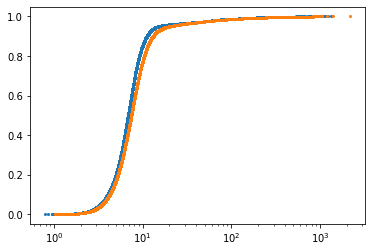

In [44]:
_, ax = plt.subplots(1, 1)
plot_cdf(ax, collect_col(baseline_sdf.where(sh_filter), "latency"), label="baseline", linewidth=0, marker='o')
plot_cdf(ax, collect_col(ddr_ts_sdf.where(sh_filter), "latency"), label="ddr_ts", linewidth=0, marker='o')

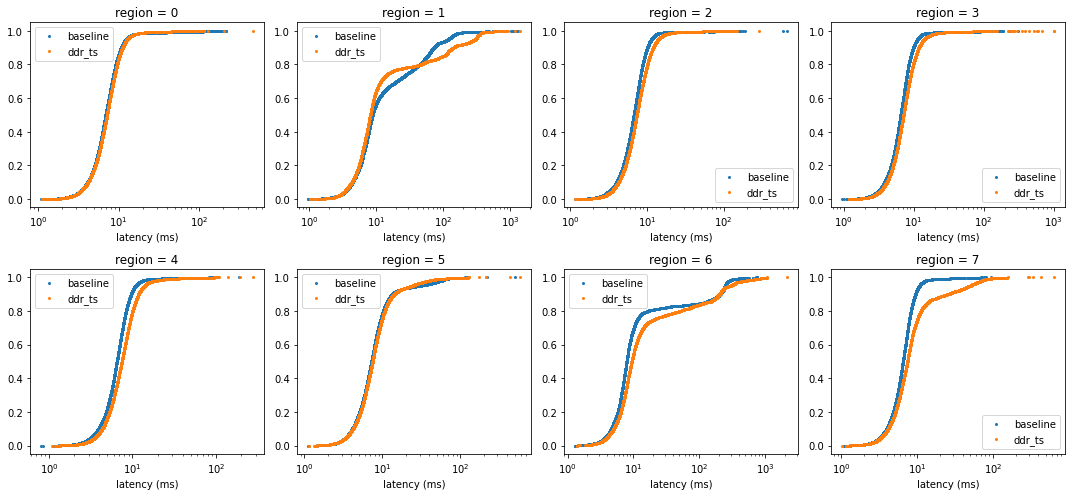

In [45]:
plot_latency_per_region({
    "baseline": baseline_sdf.where(sh_filter),
    "ddr_ts": ddr_ts_sdf.where(sh_filter),
})

plt.tight_layout()

### Multi-Home

In [26]:
mh_filter = F.size("replicas") > 1

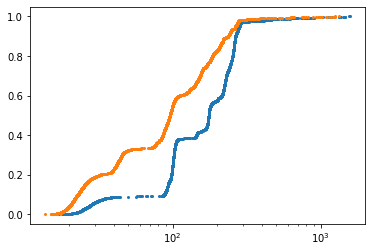

In [27]:
_, ax = plt.subplots(1, 1)
plot_cdf(ax, collect_col(baseline_sdf.where(mh_filter), "latency"), label="baseline", linewidth=0, marker='o')
plot_cdf(ax, collect_col(ddr_ts_sdf.where(mh_filter), "latency"), label="ddr_ts", linewidth=0, marker='o')

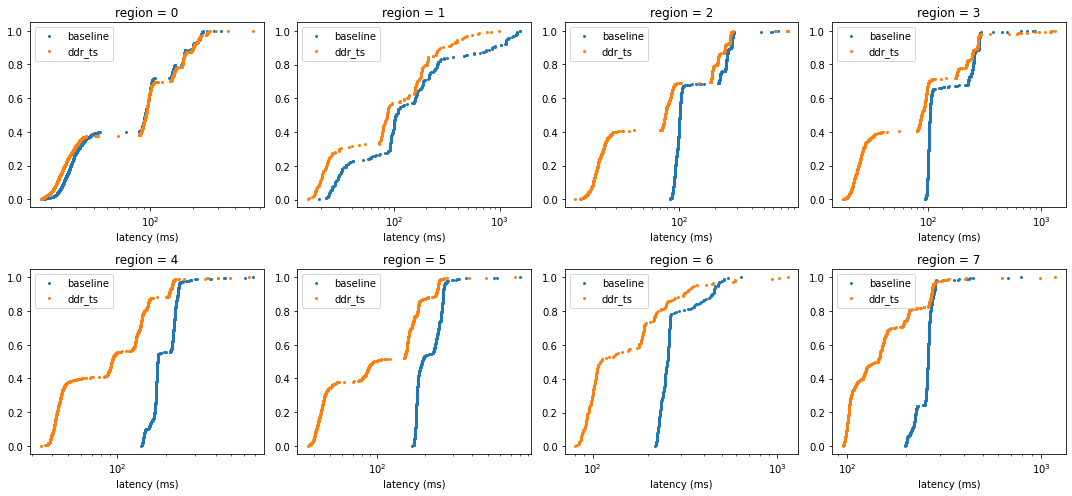

In [30]:
plot_latency_per_region({
    "baseline": baseline_sdf.where(mh_filter),
    "ddr_ts": ddr_ts_sdf.where(mh_filter),
})

plt.tight_layout()

# Ad-hoc

In [23]:
ah_baseline_sdf = baseline_sdf.where(mh_filter)\
    .where((col("coordinator_region") == 6) & (col("latency") > 300))
ah_ddr_ts_sdf = ddr_ts_sdf.where(mh_filter)\
    .where((col("coordinator_region") == 6) & (col("latency") > 300))

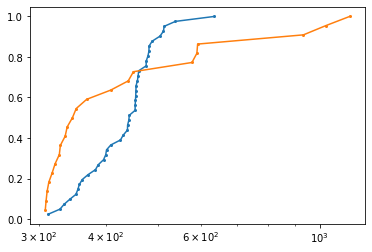

In [24]:
_, ax = plt.subplots(1, 1)
plot_cdf(ax, collect_col(ah_baseline_sdf, "latency"))
plot_cdf(ax, collect_col(ah_ddr_ts_sdf, "latency"))

In [25]:
ah_baseline_sdf.show()

+--------------------+--------+-----------+--------+----------+----------+------------------+-------+-------------+--------+----+-------+----+------+-------+----------+-----------+----------+--------+---------------+
|              prefix|  txn_id|coordinator|replicas|partitions|   latency|coordinator_region|version|  config_name|duration|txns|clients|rate|sample|wl:name|wl:sh_only|     wl:mix|wl:mh_zipf|wl:homes|wl:sp_partition|
+--------------------+--------+-----------+--------+----------+----------+------------------+-------+-------------+--------+----+-------+----+------+-------+----------+-----------+----------+--------+---------------+
|file:///home/ctri...|10696718|         18|  [3, 6]|       [0]|481.007104|                 6|1.0.916|baseline.conf|      30|   0|     75|   0|    10|   tpcc|         0|45:43:4:4:4|         1|       2|             -1|
|file:///home/ctri...|10634918|         18|  [5, 6]|       [0]| 438.92096|                 6|1.0.916|baseline.conf|      30|   0|   

In [60]:
ah_ddr_ts_sdf.show()

+--------------------+--------+-----------+--------+----------+-----------+------------------+-------+-----------+--------+----+-------+----+------+-------+----------+-----------+----------+--------+---------------+
|              prefix|  txn_id|coordinator|replicas|partitions|    latency|coordinator_region|version|config_name|duration|txns|clients|rate|sample|wl:name|wl:sh_only|     wl:mix|wl:mh_zipf|wl:homes|wl:sp_partition|
+--------------------+--------+-----------+--------+----------+-----------+------------------+-------+-----------+--------+----+-------+----+------+-------+----------+-----------+----------+--------+---------------+
|file:///home/ctri...|10292920|         20|  [4, 6]|       [0]| 308.496896|                 6|1.0.916|ddr_ts.conf|      30|   0|     75|   0|    10|   tpcc|         0|45:43:4:4:4|         1|       2|             -1|
|file:///home/ctri...|10483519|         19|  [6, 7]|       [0]| 1025.88544|                 6|1.0.916|ddr_ts.conf|      30|   0|     75|